# Data Preprocessing

In [1]:
import pandas as pd

# Read and concatenate the data files
file_paths = ['/kaggle/input/netflix-prize-data/combined_data_1.txt'
              , '/kaggle/input/netflix-prize-data/combined_data_2.txt'
              ,'/kaggle/input/netflix-prize-data/combined_data_3.txt'
              ,'/kaggle/input/netflix-prize-data/combined_data_4.txt'
             ]

dfs = []
for file_path in file_paths:
    df = pd.read_csv(file_path, header=None, names=['userId', 'rating', 'date'], usecols=[0, 1, 2])
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

# Identify indices of NaN values in 'rating' column
nan_indices = df[df['rating'].isna()].index.to_list()

# Extract ratings data
ratings = []
for i in range(len(nan_indices)):
    start_index = nan_indices[i] + 1
    end_index = nan_indices[i + 1] - 1 if i + 1 < len(nan_indices) else None
    temp_df = df.loc[start_index:end_index].reset_index(drop=True)
    temp_df['movieId'] = df.loc[nan_indices[i], 'userId'][:-1]
    ratings.append(temp_df)

df = pd.concat(ratings, ignore_index=True)
del ratings, dfs

**Data Size is huge and very difficult to manage on limited hardware configuration, hence sampling 70% of the data for EDA.**

In [2]:
df = df.sample(frac=0.7)
df.head()

,userId,rating,date,movieId
10350674,2105990,3.0,2004-12-20,2009
792119,1588043,4.0,2005-10-31,191
26691120,1301819,3.0,2005-03-04,4970
70963494,455678,4.0,2005-06-07,12870
25979689,1288835,2.0,2004-10-14,4833


# EDA

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df.shape

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(70336355, 4)

In [4]:
total_ratings = df.shape[0]
unique_users = df.userId.nunique()
unique_movies = df.movieId.nunique()

print(f'Total number of rating: {total_ratings}')
print(f'Total number of users: {unique_users}')
print(f'Total number of movies: {unique_movies}')

Total number of rating: 70336355
Total number of users: 479552
Total number of movies: 17770


So we can see there are 70,33,63,55 elements in the sparse matrix of size 479552x17770.
Therefore only 0.82% of the matrix is filled.

In [5]:
df.isna().sum()

userId     0
rating     0
date       0
movieId    0
dtype: int64

No missing values

In [6]:
df.duplicated().sum()

0

No duplicates

In [7]:
rating_distribution = df.rating.value_counts(normalize=True).reset_index()
rating_distribution

,index,rating
0,4.0,0.335883
1,3.0,0.286728
2,5.0,0.230586
3,2.0,0.100844
4,1.0,0.045959


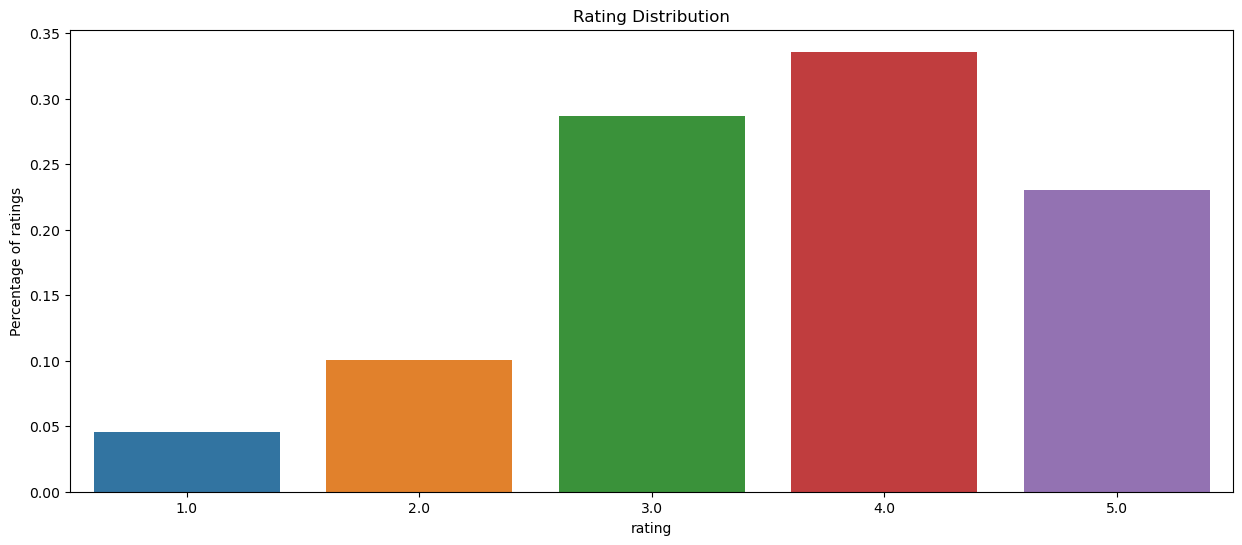

In [8]:
plt.figure(figsize=(15,6))
sns.barplot(rating_distribution, x='index',y='rating')
plt.title('Rating Distribution')
plt.xlabel('rating') 
plt.ylabel('Percentage of ratings')
del rating_distribution
plt.show()

In [9]:
df['ratings_year'] = df.date.apply(lambda x: x.split('-')[0])

In [10]:
rating_by_year = df.ratings_year.value_counts(normalize=True).reset_index()
rating_by_year

,index,ratings_year
0,2005,0.530000
1,2004,0.300603
2,2003,0.099355
3,2002,0.043219
4,2001,0.017600
5,2000,0.009202
6,1999,0.000022


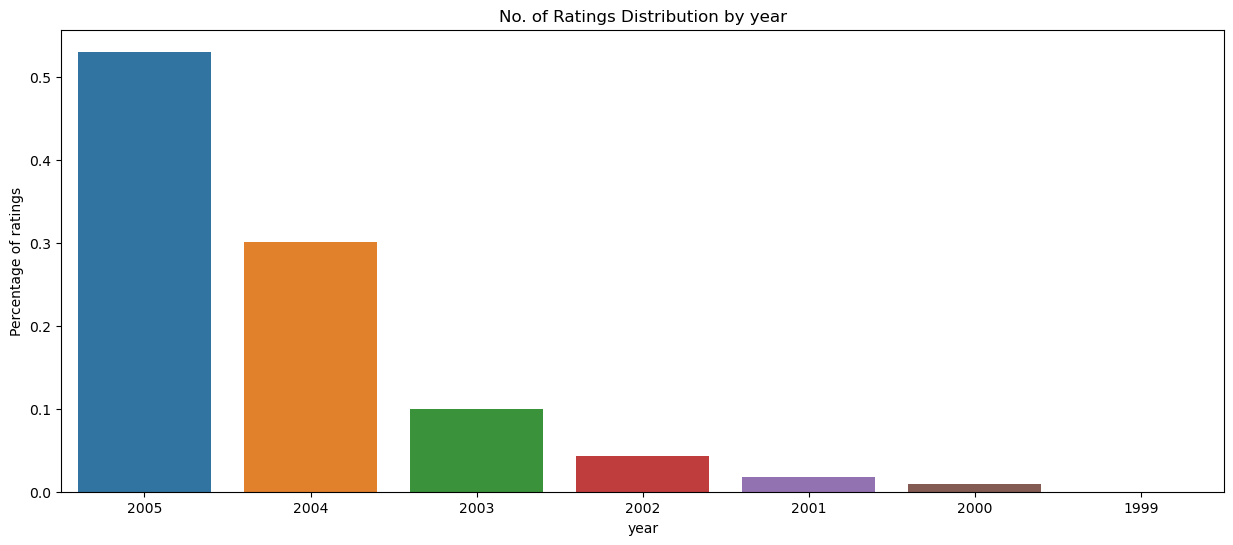

In [11]:
plt.figure(figsize=(15,6))
sns.barplot(rating_by_year, x='index',y='ratings_year')
plt.title('No. of Ratings Distribution by year')
plt.xlabel('year') 
plt.ylabel('Percentage of ratings')
del rating_by_year
plt.show()

In [12]:
movies_df = pd.read_csv('/kaggle/input/netflix-prize-data/movie_titles.csv', header=None, encoding="ISO-8859-1",
                     usecols=[0, 1, 2], names=['movieId', 'year', 'title'])

movies_df.fillna(0, inplace=True)
movies_df['year'] = movies_df['year'].astype(int)
movies_df.head()

,movieId,year,title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW


In [13]:
releases_by_year = movies_df[movies_df.year > 1800].year.value_counts(normalize=True)
releases_by_year

2004    0.080842
2002    0.073749
2003    0.071553
2000    0.069470
2001    0.066655
          ...   
1918    0.000113
1923    0.000113
1914    0.000113
1909    0.000056
1896    0.000056
Name: year, Length: 94, dtype: float64

In [14]:
len(movies_df[movies_df.year > 1900])/len(movies_df)*100

99.95498030388295

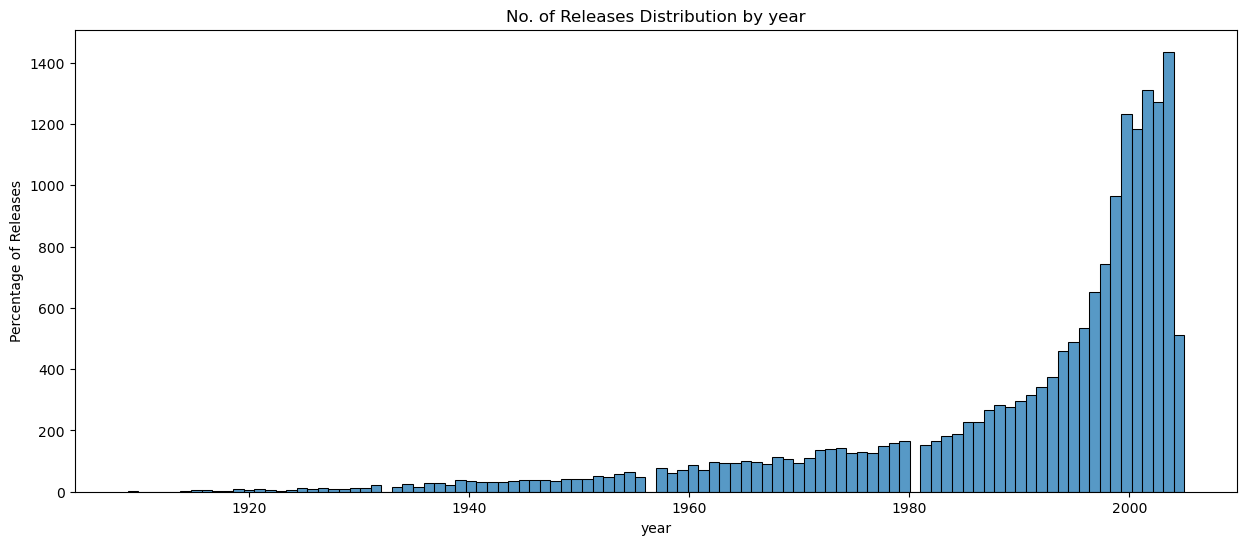

In [15]:
plt.figure(figsize=(15,6))
sns.histplot(movies_df[movies_df.year > 1900].year, bins=100)
plt.title('No. of Releases Distribution by year')
plt.xlabel('year') 
plt.ylabel('Percentage of Releases')

del movies_df, releases_by_year

plt.show()

In [16]:
# first rating
df = df.sort_values(by=['ratings_year'], ascending=True).reset_index(drop=True)
first_rating = df.drop_duplicates(subset=['userId'], keep='first')
first_rating.head()

,userId,rating,date,movieId,ratings_year
0,872963,4.0,1999-12-30,9265,1999
1,1723352,4.0,1999-12-30,8846,1999
2,122223,5.0,1999-12-18,13451,1999
3,2522229,2.0,1999-12-31,17064,1999
4,510180,4.0,1999-12-12,15472,1999


In [17]:
first_rating_by_year = first_rating.ratings_year.value_counts(normalize=True).reset_index()
first_rating_by_year

,index,ratings_year
0,2005,0.446942
1,2004,0.294243
2,2003,0.144541
3,2002,0.070368
4,2001,0.026975
5,2000,0.016772
6,1999,0.000158


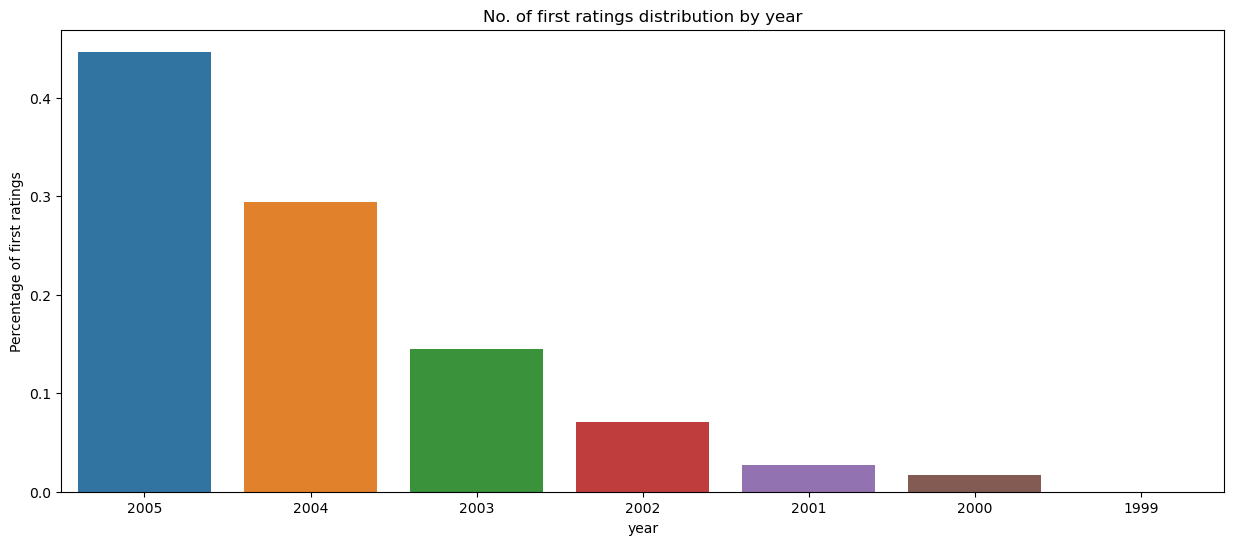

In [18]:
plt.figure(figsize=(15,6))
sns.barplot(first_rating_by_year, x='index',y='ratings_year')
plt.title('No. of first ratings distribution by year')
plt.xlabel('year') 
plt.ylabel('Percentage of first ratings')
del first_rating, first_rating_by_year
plt.show()

In [19]:
last_rating = df.drop_duplicates(subset=['userId'], keep='last')
last_rating.head()

,userId,rating,date,movieId,ratings_year
110950,1530632,4.0,2000-03-22,12818,2000
366061,611042,5.0,2000-03-22,3084,2000
415974,1176353,1.0,2000-04-27,14755,2000
443931,1904692,3.0,2000-01-07,7917,2000
460452,285679,1.0,2000-10-19,10230,2000


In [20]:
last_rating_by_year = last_rating.ratings_year.value_counts(normalize=True).reset_index()
last_rating_by_year

,index,ratings_year
0,2005,0.932243
1,2004,0.057612
2,2003,0.007073
3,2002,0.002131
4,2001,0.000621
5,2000,0.000319


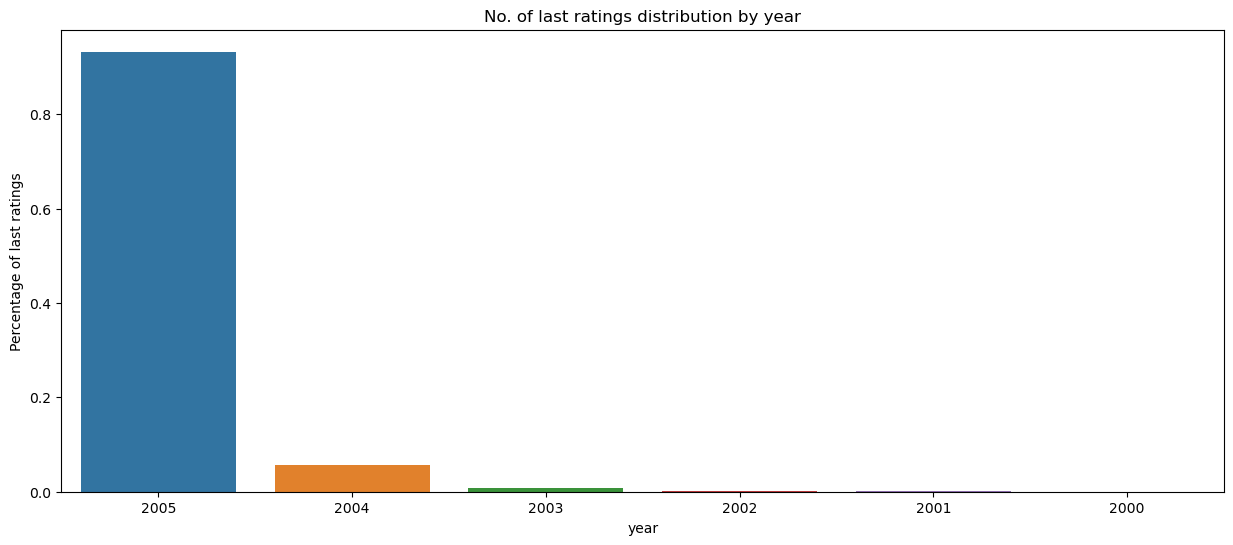

In [21]:
plt.figure(figsize=(15,6))
sns.barplot(last_rating_by_year, x='index',y='ratings_year')
plt.title('No. of last ratings distribution by year')
plt.xlabel('year') 
plt.ylabel('Percentage of last ratings')
del last_rating, last_rating_by_year
plt.show()

In [22]:
# number of ratings per user to decide top 10% users or power Users
thres = np.percentile(df.groupby('userId')['rating'].count().reset_index().rating.to_list(),90)
print('90th percentile rating count', thres)
power_users = df.groupby('userId')['rating'].count().reset_index()
power_users = power_users[power_users.rating >= thres]
power_users

90th percentile rating count 379.0


,userId,rating
11,1000062,486
16,1000079,664
35,1000192,1101
64,1000301,882
67,1000328,480
...,...,...
479454,999528,653
479469,999601,488
479503,999756,403
479505,999768,525


In [23]:
print(len(df))

p_df = df[df.userId.isin(power_users['userId'].to_list())].reset_index(drop=True)
p_df['if_power'] = 'power'
np_df = df[~(df.userId.isin(power_users['userId'].to_list()))].reset_index(drop=True)
np_df['if_power'] = 'not_power'
df = pd.concat([np_df, p_df])
del power_users,np_df, p_df
df

70336355


,userId,rating,date,movieId,ratings_year,if_power
0,122223,5.0,1999-12-18,13451,1999,not_power
1,261295,4.0,1999-12-24,11612,1999,not_power
2,228192,4.0,1999-12-31,11242,1999,not_power
3,1086,1.0,1999-12-31,6833,1999,not_power
4,261295,2.0,1999-12-24,808,1999,not_power
...,...,...,...,...,...,...
30660616,2205125,5.0,2005-10-11,7028,2005,power
30660617,1227739,1.0,2005-04-30,8189,2005,power
30660618,1696775,4.0,2005-01-25,5922,2005,power
30660619,1418305,3.0,2005-01-23,2152,2005,power


In [24]:
if_power_rating_comapre = df.groupby(['if_power'])['rating'].value_counts(normalize=True).reset_index(name='per')
if_power_rating_comapre

,if_power,rating,per
0,not_power,4.0,0.342107
1,not_power,3.0,0.263321
2,not_power,5.0,0.257607
3,not_power,2.0,0.093105
4,not_power,1.0,0.043860
5,power,4.0,0.327828
6,power,3.0,0.317017
7,power,5.0,0.195619
8,power,2.0,0.110859
9,power,1.0,0.048677


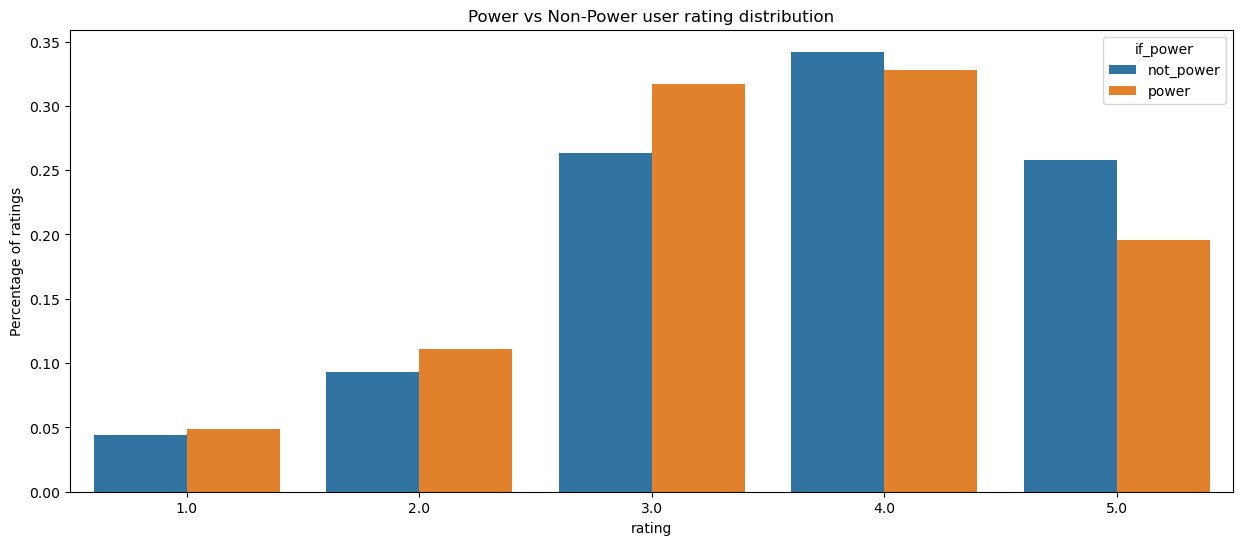

In [25]:
plt.figure(figsize=(15,6))
sns.barplot(x="rating",y="per", hue="if_power",
           data=if_power_rating_comapre)

plt.title('Power vs Non-Power user rating distribution')
plt.xlabel('rating') 
plt.ylabel('Percentage of ratings')
del if_power_rating_comapre
plt.show()

In [26]:
rating_by_year_compare = df.groupby(['ratings_year'])['rating'].value_counts(normalize=True).reset_index(name='per')
rating_by_year_compare

,ratings_year,rating,per
0,1999,3.0,0.318602
1,1999,4.0,0.281003
2,1999,5.0,0.173483
3,1999,2.0,0.145119
4,1999,1.0,0.081794
5,2000,3.0,0.316916
6,2000,4.0,0.302228
7,2000,5.0,0.170540
8,2000,2.0,0.143106
9,2000,1.0,0.067211


In [27]:
len(df[df.ratings_year<='2001'])/len(df)*100

2.682393763509639

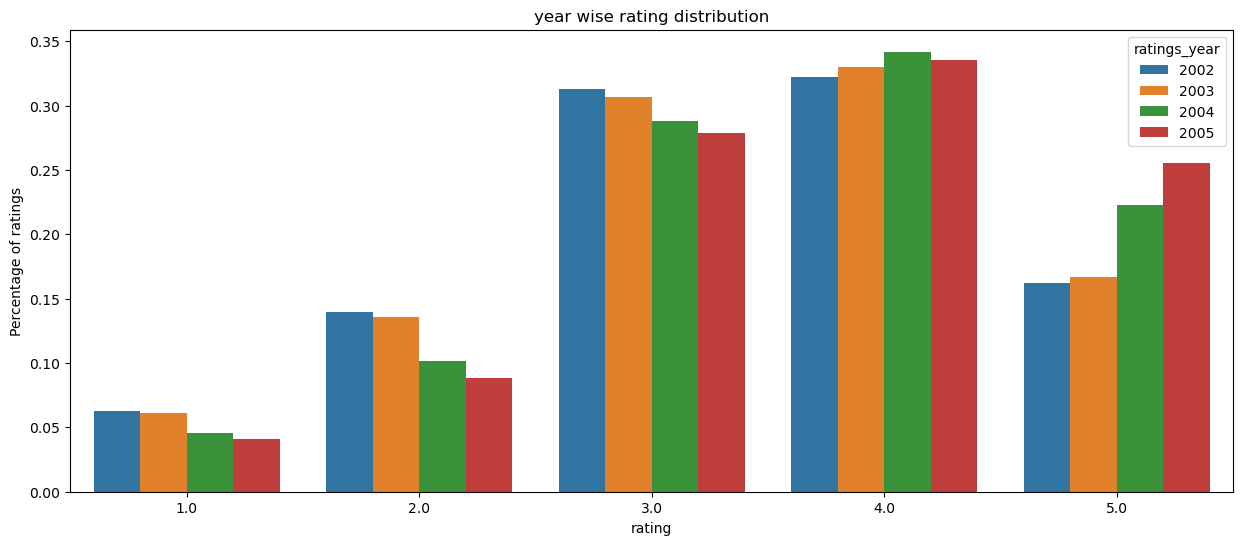

In [28]:
plt.figure(figsize=(15,6))
sns.barplot(x="rating",y="per", hue="ratings_year",
           data=rating_by_year_compare[rating_by_year_compare.ratings_year >='2002'])

plt.title('year wise rating distribution')
plt.xlabel('rating') 
plt.ylabel('Percentage of ratings')
del rating_by_year_compare
plt.show()